In [1]:
import sys

import numpy  as np
import pandas as pd
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import utils

from CFLib.euro_opt import impVolFromFwPut

### Heston Model: 
\begin{align*}
& dS_t = r_0 S_t dt + \sqrt{v_t} S_t dW_t^1 \\
& dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^2 \\
& dW_t^1 dW_t^2 = \rho dt
\end{align*}

- $S_t$ represents the asset price at time $t$
- $v_t$ represents the instantaneous variance of the asset price at time $t$
- $r_0$ is the risk-free interest rate, $\kappa$ is the mean reversion rate of the variance
- $\theta$ is the long-term average variance, $\sigma$ is the volatility of volatility
- $W_t^1$ and $W_t^2$ are two correlated Wiener processes (Brownian motions) with correlation $\rho$

In [3]:
seed    = 38520208

rand    = np.random.RandomState(seed)
mInt    = (1 << 15)
MInt    = (1 << 16)

log_n   = 17
NUM     = (1 << log_n)

EPS     = 0

outputPrfx    = "full"

bounds = { "k":       [2.00   , 6.00]     # mean-reversion speed
         , "theta":   [ .01   ,  .20]     # long-term variance
         , "sigma":   [1.00   , 2.50]     # volatility of volatility
         , "r0":      [ .01   ,  .20]     # initial variance
         , "rho":     [-.90   , -.50]     # spot-vol correlation
         , "T":       [ .10   , 2.00]
         , "Strike":  [ .50   , 1.50]
         }

if the parameters obey the following Feller condition $2 \kappa \theta < \sigma^2$  then the process $\nu_t$ is strictly positive

In [19]:
params_name = list(bounds.keys())

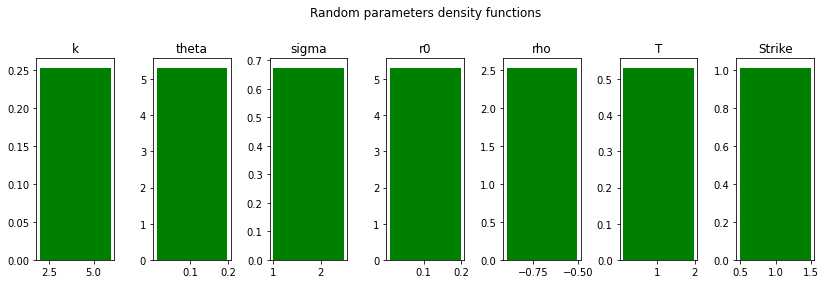

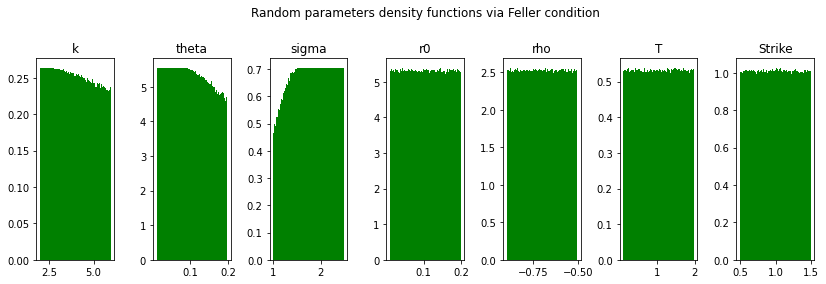

In [21]:
xDF = utils.lhs_sampling(rand, NUM, bounds=bounds)
xDF["Feller"] = 2*xDF["k"]*xDF["theta"] < np.power( xDF["sigma"], 2)
utils.histo_params( xDF[params_name], title = "Random parameters density functions")
utils.histo_params( xDF[xDF["Feller"] == True][params_name], title = "Random parameters density functions via Feller condition")

In [25]:
print("% of point that satisfy the feller conditions:", xDF["Feller"].sum()/xDF.shape[0])

% of point that satisfy the feller conditions: 0.9563674926757812


### Generate price using Heston Model (this use fast fourier transform)

In [33]:
__tStart = time.perf_counter()
yDF = utils.gen_Hes(NUM, xDF)
__tEnd   = time.perf_counter()
print("@ %-11s: elapsed %.4f sec" %("GEN", __tEnd - __tStart))

C:\Users\LEI00068\Desktop\Progetti\unibo\advanced-ML-2023-Amabili\notebook\Lab_3\pnt_calibration\utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Price"][m] = fwPut


@ GEN        : elapsed 3851.8902 sec


### Use price to compute implied volatility

implied volatility is computed by solving the following optimization problem:

$\sigma_{imp} = argmin_{\sigma} (p_{BS}(\sigma, T, K) - p_{model}({params}, T, K))^2$ 

or equivalently find $\sigma$ such that (root finding problem):

$p_{BS}(\sigma, T, K) - p_{model}({params}, T, K) = 0$

with ${params}, T, K$ fixed. BS stands for Black-Scholes Model.


In [37]:
ivol = []
for k,t,p in zip(yDF["Strike"], yDF["T"], yDF["Price"]):
    ivol.append(impVolFromFwPut(p, t, k))

In [38]:
yDF["imp_vol"] = ivol

In [40]:
full = yDF
outputFile = "%s_%d.csv" %(outputPrfx, seed)
full.to_csv(outputFile, sep=',', float_format="%.6f", index=False)
print("@ %-11s: training data frame written to '%s'" %("Info", outputFile))
print(full)

@ Info       : training data frame written to 'full_38520208.csv'
               k     theta     sigma        r0       rho         T    Strike  \
0       3.814102  0.164540  1.432833  0.139525 -0.716335  1.643699  0.595936   
1       4.696243  0.091518  1.783571  0.112681 -0.743819  0.447255  1.272533   
2       3.673141  0.170460  2.493242  0.120849 -0.554280  1.552593  1.130810   
3       4.133072  0.193795  1.853701  0.073172 -0.545845  1.926426  0.947033   
4       2.782822  0.143705  1.232721  0.102763 -0.817616  0.871505  0.567104   
...          ...       ...       ...       ...       ...       ...       ...   
131067  5.961929  0.057385  1.973806  0.015464 -0.840514  0.583676  1.478237   
131068  4.868423  0.122577  1.691961  0.016508 -0.776970  0.322388  1.094593   
131069  5.122147  0.190196  1.186991  0.017469 -0.792909  1.624869  0.648182   
131070  5.812271  0.069625  1.402334  0.020832 -0.746422  0.973266  0.553593   
131071  5.036087  0.070725  1.116381  0.026261 -0.8196

In [39]:
#yDF = yDF.drop(columns=["Price", "Feller"])